In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [2]:

def get_stock_data(stock_name, normalized=0):
#     url="http://www.google.com/finance/historical?q="+stock_name+"&startdate=Jul+12%2C+2013&enddate=Jul+11%2C+2017&num=30&ei=rCtlWZGSFN3KsQHwrqWQCw&output=csv"
#     url="http://www.google.com/finance/historical?q=%s&ei=u-lHWfGPNNWIsgHHqIqICw&output=csv" % stock_name 

    url = 'dataset/googl.csv'
    col_names = ['Date','Open','High','Low','Close','Volume']
    stocks = pd.read_csv(url, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    df.drop(df.columns[[0,3,5]], axis=1, inplace=True) 
    return df

In [3]:

stock_name = 'GOOGL'
df = get_stock_data(stock_name,0)
df.tail()

,Open,High,Close
1002,459.95,460.46,455.80
1003,460.96,463.89,459.73
1004,464.03,464.45,460.26
1005,462.61,464.46,462.81
1006,460.46,461.96,461.96


In [4]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv('dataset/'+file_name)

In [5]:

df['High'] = df['High'] / 1000
df['Open'] = df['Open'] / 1000
df['Close'] = df['Close'] / 1000
df.head(5)

,Open,High,Close
0,0.95052,0.95489,0.95353
1,0.94195,0.95313,0.95100
2,0.93098,0.94466,0.94081
3,0.92500,0.93614,0.92769
4,0.92420,0.93629,0.93226


In [18]:
def load_data(stock, seq_len):
    amount_of_features = stock.shape[1]
    data = stock.as_matrix()
    print(data.shape)
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    print(train.shape)
    x_train = train[:, : -1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [19]:
def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(
        input_dim=layers[0],
        output_dim = layers[1],
        return_sequences = True
    ))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        Layers[2],
        return_sequences = False
    ))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        output_dim = layers[2]
    ))
    model.add(Activation ("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer = "rmsprop", metrics=["accuracy"])
    print("Compilation Time:", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(
            128, 
            input_shape=(layers[1], layers[0]), 
            return_sequences=True
        ))
        model.add(Dropout(d))
        
        model.add(LSTM(
            64, 
            input_shape=(layers[1], layers[0]), 
            return_sequences=False
        ))
        model.add(Dropout(d))
        
        model.add(Dense(
            16,
            kernel_initializer='uniform',
            activation='relu'
        ))        
        
        model.add(Dense(
            1,
            kernel_initializer='uniform',
            activation='relu'
        ))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [20]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

(1007, 3)
(901, 6, 3)
X_train (901, 5, 3)
y_train (901,)
X_test (100, 5, 3)
y_test (100,)


In [21]:

# model = build_model([3,lag,1])
model = build_model2([3,window,1])

In [27]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1,
    verbose=0)

In [28]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.04 RMSE)


In [29]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

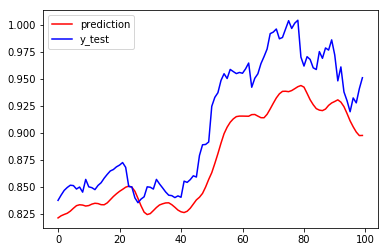

In [30]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()